In [3]:
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from scipy.sparse import hstack
import re
import string
import seaborn as sns

# Data Cleaning

In [4]:
df = pd.read_csv(
    "redditSubmissions.csv.gz",
    compression='gzip',
    engine='python',
    on_bad_lines='skip'
)

print(df.shape)
print(df.columns)
df.head()

(132303, 13)
Index(['#image_id', 'unixtime', 'rawtime', 'title', 'total_votes', 'reddit_id',
       'number_of_upvotes', 'subreddit', 'number_of_downvotes', 'localtime',
       'score', 'number_of_comments', 'username'],
      dtype='object')


,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,username
0,0,1.333172e+09,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470.0,rmqjs,32657.0,funny,30813.0,1.333198e+09,1844.0,622.0,Animates_Everything
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,Expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,23.0,3.0,Gangsta_Raper
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,Downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,23.0,0.0,Gangsta_Raper
3,0,1.333252e+09,2012-04-01T10:52:10-07:00,Every time I downvote something,10.0,ro7e4,6.0,GifSound,4.0,1.333278e+09,2.0,0.0,Gangsta_Raper
4,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65.0,rooof,57.0,GifSound,8.0,1.333298e+09,49.0,0.0,Gangsta_Raper


In [5]:
# Cleaning datetime
df['datetime'] = pd.to_datetime(df['rawtime'], errors='coerce')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime']).copy()
print(df.shape)


(10051, 14)


/var/folders/th/bl1jb0c5047__rnfd6k3zd2r0000gn/T/ipykernel_47819/2085476778.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['datetime'] = pd.to_datetime(df['rawtime'], errors='coerce')


In [6]:
# Dropping all null scores (ie. upvotes - downvotes)
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df = df.dropna(subset=['score']).copy()

# Imputation and removing missing values for key features
df['title'] = df['title'].fillna('').astype(str)
df = df.dropna(subset=['subreddit', 'username', 'datetime'])

print(df.shape)

(8512, 14)


## Feature Creation

In [7]:
# Time-of-day features
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

In [8]:
# Title features
df['title_length'] = df['title'].apply(len)
df['word_count'] = df['title'].apply(lambda x: len(x.split()))
df['is_question'] = df['title'].str.contains('?', regex=False).astype(int)
df['is_exclamation'] = df['title'].str.contains('!', regex=False).astype(int)

sub = df

In [9]:
# Subreddit agg features
subreddit_stats = df.groupby('subreddit')['score'].agg(
    subreddit_mean_score='mean',
    subreddit_post_count='count'
).reset_index()

df = df.merge(subreddit_stats, on='subreddit', how='left')

# Log-transformation of score for ridge linear model
df['score_log'] = np.log1p(df['score'].clip(lower=0))

df.head()

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,...,hour,dayofweek,is_weekend,title_length,word_count,is_question,is_exclamation,subreddit_mean_score,subreddit_post_count,score_log
0,0,1.333172e+09,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470.0,rmqjs,32657.0,funny,30813.0,1.333198e+09,...,12,5,1,22,4,0,0,234.263602,2371,7.520235
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,Expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,...,14,5,1,11,1,0,0,15.671053,152,3.178054
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,Downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,...,20,5,1,8,1,0,0,15.671053,152,3.178054
3,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65.0,rooof,57.0,GifSound,8.0,1.333298e+09,...,16,6,1,30,3,0,0,15.671053,152,3.912023
4,0,1.339425e+09,2012-06-11T21:34:51.692933-07:00,Every LastAirBender post with a NSFW tag,20.0,uxf5q,9.0,pics,11.0,1.339450e+09,...,21,0,0,40,7,0,0,230.191052,1654,0.000000


In [10]:
# Sentiment Feature
# from textblob import TextBlob

# df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)


# Exploratory Data Analysis

In [11]:
# Basic Data Overview

print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
df.head()

Number of rows: 8512
Number of columns: 24


,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,...,hour,dayofweek,is_weekend,title_length,word_count,is_question,is_exclamation,subreddit_mean_score,subreddit_post_count,score_log
0,0,1.333172e+09,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470.0,rmqjs,32657.0,funny,30813.0,1.333198e+09,...,12,5,1,22,4,0,0,234.263602,2371,7.520235
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,Expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,...,14,5,1,11,1,0,0,15.671053,152,3.178054
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,Downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,...,20,5,1,8,1,0,0,15.671053,152,3.178054
3,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65.0,rooof,57.0,GifSound,8.0,1.333298e+09,...,16,6,1,30,3,0,0,15.671053,152,3.912023
4,0,1.339425e+09,2012-06-11T21:34:51.692933-07:00,Every LastAirBender post with a NSFW tag,20.0,uxf5q,9.0,pics,11.0,1.339450e+09,...,21,0,0,40,7,0,0,230.191052,1654,0.000000


In [12]:
# Column Summary

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8512 entries, 0 to 8511
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype                    
---  ------                --------------  -----                    
 0   #image_id             8512 non-null   int64                    
 1   unixtime              8512 non-null   float64                  
 2   rawtime               8512 non-null   object                   
 3   title                 8512 non-null   object                   
 4   total_votes           8512 non-null   float64                  
 5   reddit_id             8512 non-null   object                   
 6   number_of_upvotes     8512 non-null   float64                  
 7   subreddit             8512 non-null   object                   
 8   number_of_downvotes   8512 non-null   float64                  
 9   localtime             8512 non-null   float64                  
 10  score                 8512 non-null   float64               

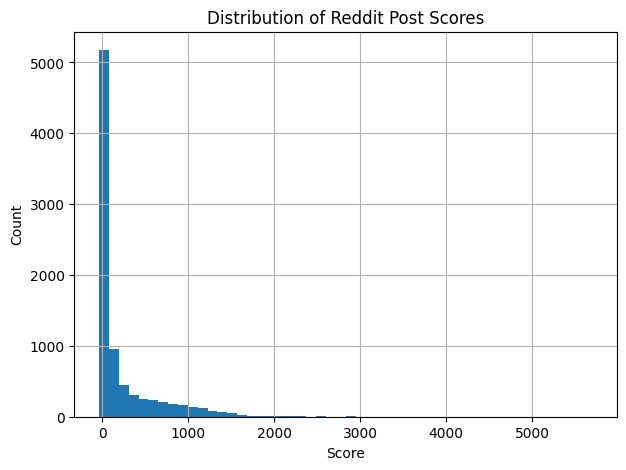

In [13]:
# Distribution of Reddit Scores

plt.figure(figsize=(7,5))
df['score'].hist(bins=50)
plt.title("Distribution of Reddit Post Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

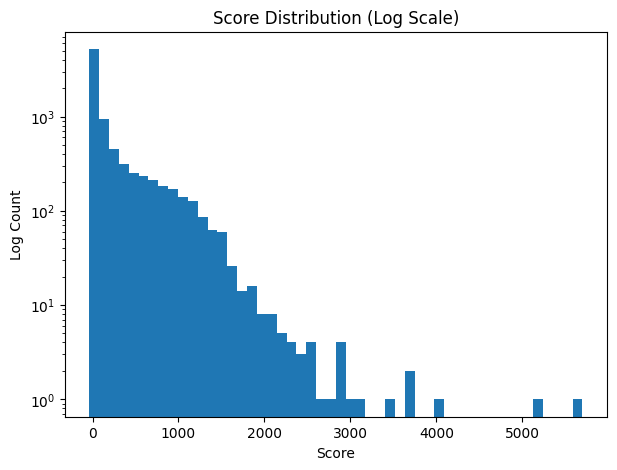

In [14]:
# Log Distribution of Reddit Scores

plt.figure(figsize=(7,5))
plt.hist(df['score'], bins=50, log=True)
plt.title("Score Distribution (Log Scale)")
plt.xlabel("Score")
plt.ylabel("Log Count")
plt.show()

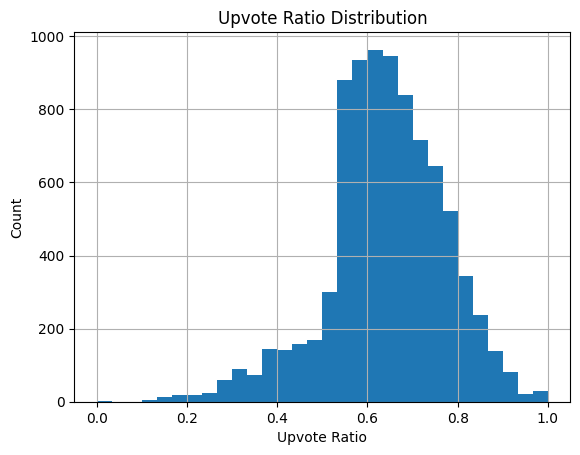

In [15]:
# Upvote ratio
df['upvote_ratio'] = df['number_of_upvotes'] / (df['total_votes'] + 1e-9)
df['upvote_ratio'].hist(bins=30)
plt.title("Upvote Ratio Distribution")
plt.xlabel("Upvote Ratio")
plt.ylabel("Count")
plt.show()


In [16]:
# Subreddit Frequencies in our Dataset

df['subreddit'].value_counts().head(20)

subreddit
funny                  2371
pics                   1654
WTF                    1516
gifs                    810
atheism                 775
gaming                  310
aww                     238
GifSound                152
AdviceAnimals           118
reddit.com               87
fffffffuuuuuuuuuuuu      75
gif                      55
trees                    54
reactiongifs             43
woahdude                 22
space                    17
creepy                   11
pokemon                  10
geek                     10
movies                    9
Name: count, dtype: int64

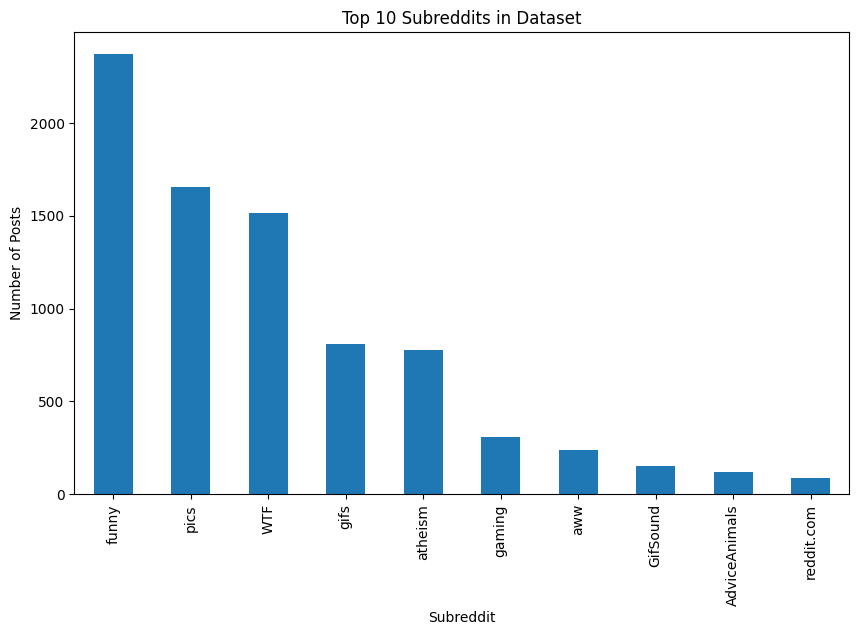

In [17]:
# Visualizing the top 10 Subreddits

plt.figure(figsize=(10,6))
df['subreddit'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Subreddits in Dataset")
plt.xlabel("Subreddit")
plt.ylabel("Number of Posts")
plt.show()


In [18]:
# Score for each Top 10 Subreddits

plt.figure(figsize=(12,6))
df[df['subreddit'].isin(top_subs)].boxplot(
    column='score',
    by='subreddit',
    figsize=(12,6),
    rot=45,
    showfliers=False
)
plt.title("Score Distribution by Top Subreddits (No Outliers Shown)")
plt.suptitle("")
plt.xlabel("Subreddit")
plt.ylabel("Score")
plt.show()

NameError: name 'top_subs' is not defined

<Figure size 1200x600 with 0 Axes>

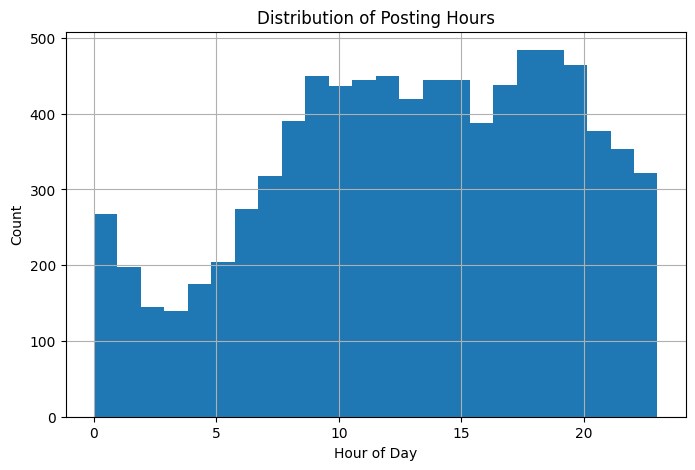

In [19]:
# Frequency of Posts by Hour of the Day

plt.figure(figsize=(8,5))
df['hour'].hist(bins=24)
plt.title("Distribution of Posting Hours")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.show()


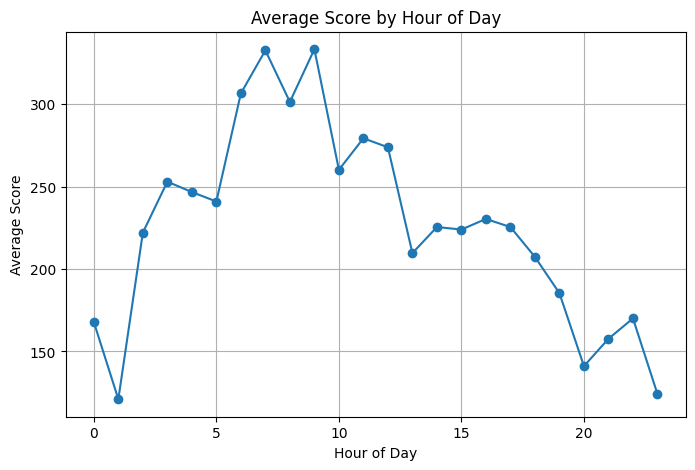

In [20]:
# Score per Hour of the Day

hourly_scores = df.groupby('hour')['score'].mean()

plt.figure(figsize=(8,5))
hourly_scores.plot(kind='line', marker='o')
plt.title("Average Score by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Score")
plt.grid(True)
plt.show()


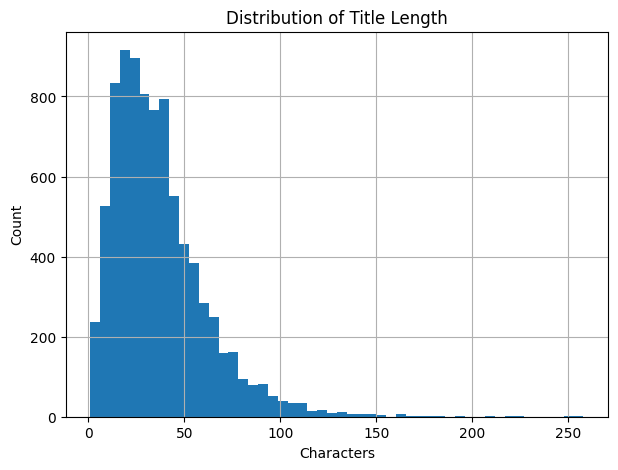

In [21]:
# Title Length Distribution by Characters

plt.figure(figsize=(7,5))
df['title_length'].hist(bins=50)
plt.title("Distribution of Title Length")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

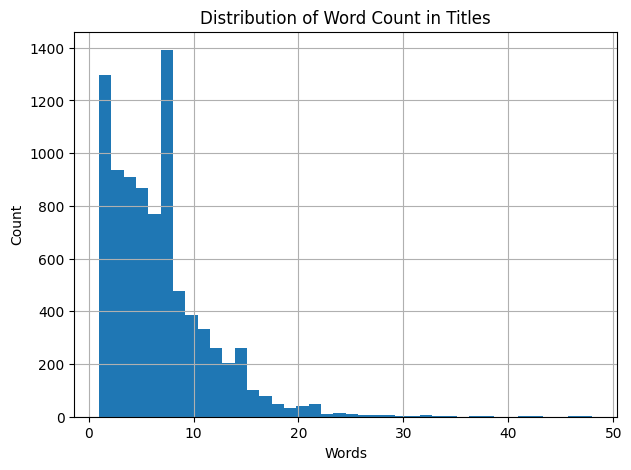

In [22]:
# Title Length Distribution by Words

plt.figure(figsize=(7,5))
df['word_count'].hist(bins=40)
plt.title("Distribution of Word Count in Titles")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

In [23]:
# Frequency of ? and ! in Posts

print("% of titles with '?':", df['is_question'].mean()*100, "%")
print("% of titles with '!':", df['is_exclamation'].mean()*100, "%")


% of titles with '?': 8.282424812030076 %
% of titles with '!': 8.670112781954888 %


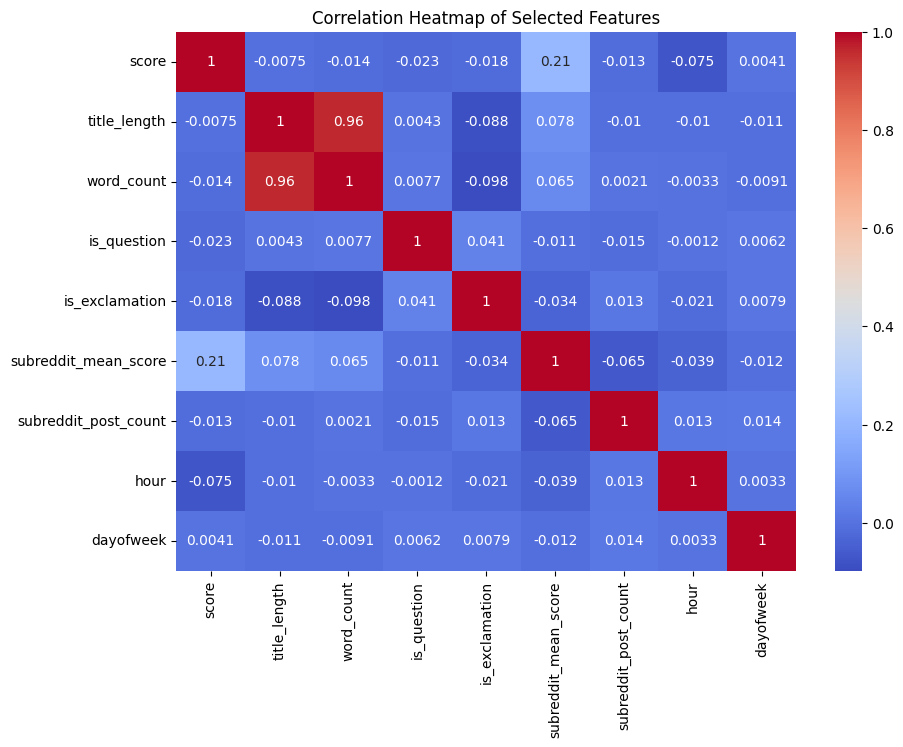

In [24]:
# Heatmap to view correlation between quantitative features

numeric_cols = [
    'score',
    'title_length',
    'word_count',
    'is_question',
    'is_exclamation',
    'subreddit_mean_score',
    'subreddit_post_count',
    'hour',
    'dayofweek'
]

corr = df[numeric_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Selected Features")
plt.show()

In [25]:
# strong correlation between title length / word count and whether the post has an exclamation or not. 
# the correlation being negative indicates titles with exclamation tend to be shorter.
# also, there seems to be a high correlation between score and hour. 

# Modeling

### Predictive Task:

Our goal is to predict the final popularity of a Reddit post at the instant it is created, using only features available at posting time. We model this as a regression problem.

#### Input (features)
- Posting time features: hour, day of week, weekend
- Subreddit-level features: mean score, post count
- Title features: length, word count, binary question/exclamation flags
- TF-IDF embedding of the post title

#### Output (labels)
- Final Reddit score (upvotes - downvotes)

### Objective:
To minimize Mean Squared Error (MSE) on validation and test data.

### Train Validation Test Split
We are doing a chronological split to mimic realtime data and capture historical trends within our model.
- 70% Training
- 15% Validation
- 15% Test

In [26]:
df = df.sort_values('datetime').reset_index(drop=True)

# 70/15/15 split
n = len(df)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

print(df_train.shape, df_val.shape, df_test.shape)


(5958, 25) (1277, 25) (1277, 25)


### Recompute Subreddit Aggregates
We have to recalculate the subreddit aggregates based on the new splits.

In [27]:
# from TRAIN only
sub_mean = df_train.groupby('subreddit')['score'].mean()
sub_count = df_train.groupby('subreddit').size()

df_train['subreddit_mean_score'] = df_train['subreddit'].map(sub_mean)
df_val['subreddit_mean_score']   = df_val['subreddit'].map(sub_mean)
df_test['subreddit_mean_score']  = df_test['subreddit'].map(sub_mean)

df_train['subreddit_post_count'] = df_train['subreddit'].map(sub_count)
df_val['subreddit_post_count']   = df_val['subreddit'].map(sub_count)
df_test['subreddit_post_count']  = df_test['subreddit'].map(sub_count)


### Baseline Model 1: Global Mean Model
This model predicts the same value for every post.

In [36]:
# Imputing global means to missing values
global_mean = df_train['score'].mean()

for split in [df_train, df_val, df_test]:
    split['subreddit_mean_score'] = split['subreddit_mean_score'].fillna(global_mean)
    split['subreddit_post_count'] = split['subreddit_post_count'].fillna(0)

# MSE with Global Mean
def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

val_pred = np.full(len(df_val), global_mean)
test_pred = np.full(len(df_test), global_mean)

print("Global Mean Baseline:")
print("Val MAE:", mae(df_val['score'], val_pred))
print("Test MAE:", mae(df_test['score'], test_pred))

Global Mean Baseline:
Val MAE: 289.1291676819963
Test MAE: 290.6564845855207


### Baseline Model 2: Subreddit Mean Model
This model predicts the mean score of each respective subreddit from the training data.

In [37]:
val_pred = df_val['subreddit_mean_score'].fillna(global_mean)
test_pred = df_test['subreddit_mean_score'].fillna(global_mean)

print("Subreddit Mean Baseline:")
print("Val MAE:", mae(df_val['score'], val_pred))
print("Test MAE:", mae(df_test['score'], test_pred))


Subreddit Mean Baseline:
Val MAE: 285.15504670674744
Test MAE: 292.5171098865832


### Model 1: Linear Regression

#### Features:
- hour
- dayofweek
- is_weekend
- title_length
- word_count
- is_question
- is_exclamation
- subreddit_mean_score
- subreddit_post_count

In this model, we are only using structured, quantitative features.

In [38]:
features = [
    'hour', 'dayofweek', 'is_weekend',
    'title_length', 'word_count',
    'is_question', 'is_exclamation',
    'subreddit_mean_score', 'subreddit_post_count'
]

X_train = df_train[features]
X_val   = df_val[features]
X_test  = df_test[features]

y_train = df_train['score_log'] #Note: we are using log score for stability
y_val   = df_val['score_log']
y_test  = df_test['score_log']

linreg = LinearRegression()
linreg.fit(X_train, y_train)

val_pred = linreg.predict(X_val)
test_pred = linreg.predict(X_test)

print("Linear Regression (log-score)")
print("Val MAE:", mae(y_val, val_pred))
print("Test MAE:", mae(y_test, test_pred))

Linear Regression (log-score)
Val MAE: 2.325196576188033
Test MAE: 2.4004055752563604


In [39]:
raw_pred = np.expm1(test_pred)
raw_true = np.expm1(y_test)
mae(raw_true, raw_pred)

np.float64(164.4379583065956)

### Model 2: Ridge Regression
Compared to linear regression, ridge regression better handles multicollinearity and reduces overfitting.

In [40]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

val_pred = ridge.predict(X_val)
test_pred = ridge.predict(X_test)

print("Ridge Regression (log-score)")
print("Val MAE:", mae(y_val, val_pred))
print("Test MAE:", mae(y_test, test_pred))

Ridge Regression (log-score)
Val MAE: 2.3252010882294334
Test MAE: 2.4003995468375243


In [41]:
raw_pred = np.expm1(test_pred)
raw_true = np.expm1(y_test)
mae(raw_true, raw_pred)

np.float64(164.43557456390607)

### Model 3: TF-IDF + Ridge Regression
In the previous two models, we only utilized quantitative features. With this Reddit data, we are offered rich Title data which could inform our score prediction. TF-IDF transforms the title text into vector representation.

In [42]:
# TF-IDF
tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1,2),
    stop_words='english'
)

tfidf_train = tfidf.fit_transform(df_train['title'])
tfidf_val   = tfidf.transform(df_val['title'])
tfidf_test  = tfidf.transform(df_test['title'])

# Numeric features (convert to sparse)
X_train_num = df_train[features]
X_val_num   = df_val[features]
X_test_num  = df_test[features]

X_train_full = hstack([tfidf_train, X_train_num])
X_val_full   = hstack([tfidf_val, X_val_num])
X_test_full  = hstack([tfidf_test, X_test_num])

ridge_tfidf = Ridge(alpha=1.0)
ridge_tfidf.fit(X_train_full, y_train)

val_pred = ridge_tfidf.predict(X_val_full)
test_pred = ridge_tfidf.predict(X_test_full)

print("TF-IDF + Ridge Regression (log-score)")
print("Val MAE:", mae(y_val, val_pred))
print("Test MAE:", mae(y_test, test_pred))


TF-IDF + Ridge Regression (log-score)
Val MAE: 2.333687842622141
Test MAE: 2.402559516572169


In [43]:
raw_pred = np.expm1(test_pred)
raw_true = np.expm1(y_test)
mae(raw_true, raw_pred)

np.float64(174.96120045526413)

#### Advantages of Baselines
- Global Mean: trivial to compute, sets a clear lower bound
- Subreddit Mean: captures community-level behavior cheaply

#### Advantages of Linear Regression
- Highly interpretable coefficients
- Fast and easy to train
- Handles numeric features transparently

#### Disadvantages of Linear Regression
- Sensitive to outliers
- Struggles with nonlinear interactions
- Cannot understand text without feature engineering

#### Advantages of Ridge Regression
- Regularization prevents overfitting
- Handles correlated features
- Works well with TF-IDF due to high dimensionality

#### Advantages of TF-IDF + Ridge
- Captures semantic meaning of titles
- Best model in terms of validation MSE
- Balanced performance and interpretability

#### Disadvantages of TF-IDF + Ridge
- Larger feature space
- More complex to implement
- Sparse matrices require careful handling